In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
model = models.vgg16(pretrained = True).to(device)

c:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [4]:
training_data_path = 'data/archive/training_set/training_set/'
test_data_path = 'data/archive/test_set/test_set/'

In [5]:
class CatsDogs(Dataset):
    def __init__(self,folder):
        print(folder + 'cats/*.jpg')
        self.cats = glob(folder + 'cats/*.jpg')
        self.dogs = glob(folder + 'dogs/*.jpg')
        self.fpaths = self.cats[:10] + self.dogs[:10]
        self.normalize = transforms.Normalize(mean=[0.485,0.456,.0442],std=[0.223,0.202,0.221])
        from random import shuffle, seed; seed(10);
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath \
        in self.fpaths]
    def __len__(self):
        return len(self.targets)
    def __getitem__(self,ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im,(224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return (
            im.float().to(device),
            torch.tensor([target]).float().to(device)
        )

data/archive/training_set/training_set/cats/*.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


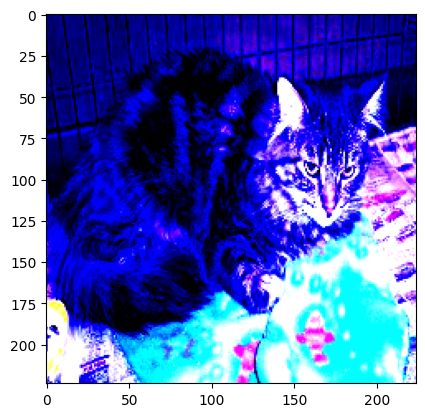

In [6]:
data = CatsDogs(training_data_path)
im,target = data[5]
plt.imshow(im.permute(1,2,0).cpu())

In [7]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [10]:
for idx, n in enumerate(model.modules()):
    print (idx , '--->' , n)

0 ---> VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [11]:
model ,loss_fn,optimizer = get_model()
summary(model,torch.zeros([1,3,224,224]))

c:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [12]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [13]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [14]:
def get_data():
    train = CatsDogs(training_data_path)
    trn_dl = DataLoader(train, batch_size=10, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_path)
    val_dl = DataLoader(val, batch_size=10, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [15]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

data/archive/training_set/training_set/cats/*.jpg
data/archive/test_set/test_set/cats/*.jpg


In [16]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(2):
    print(f" epoch {epoch + 1}/2")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/2
 epoch 2/2


In [17]:
val_accuracies

[0.95, 0.95]

C:\Users\MASOUD\AppData\Local\Temp\ipykernel_15604\2161258908.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


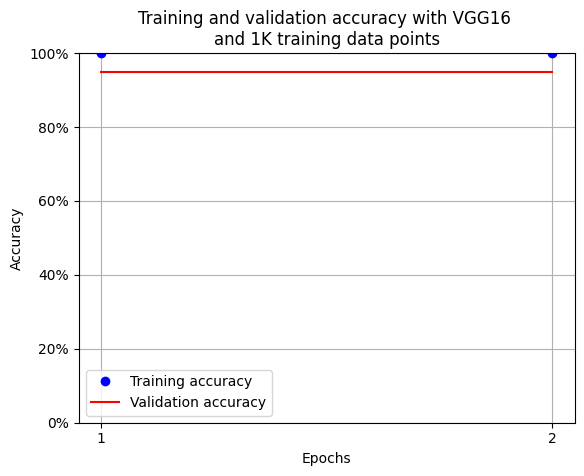

In [18]:
epochs = np.arange(2)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.0,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

#Rest Net samples
from torch import Tensor, nn
from torch.nn import Flatten,Linear,ZeroPad1d
class ResLayer(nn.Module):
    def __init__(self,ni,no,kernel_size,stride = 1):
        super(ResLayer,self).__init__()
        padding = kernel_size -2
        self.conv = nn.Sequential(
            nn.Conv2d(ni,no,kernel_size,stride,padding=padding),
            nn.ReLU()
        )

    def forward(self,x):
        print('shape of x {}',x.shape)
        print('shape of convolved {}',self.conv(x).shape)
        convolved = self.conv(x)
        flatten_convloved = Flatten()(convolved).view(-1)
        flatten_x = Flatten()(x).view(-1)

        print('shape of flatten x {}',flatten_x.shape)
        print('shape of flatten x convolved {}',flatten_convloved.shape)

        flatten_convloved = ZeroPad1d((flatten_x.shape[0] - flatten_convloved.shape[0])/2)(flatten_convloved)
        #output_with_shape_of_x = Linear(flatten_convloved.shape[1],flatten_x.shape[1])(flatten_convloved)
        print('shape of flatten convolved ',flatten_convloved.shape)
        print('shape of output_with_shape_of_x ',flatten_convloved.shape)
        x = torch.add(flatten_convloved , flatten_x)
        print('shape of output {}',x.shape)
        return x

## RestNet 18

In [21]:
model = models.resnet18(weights = True).to(device)
model

c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
def get_model():
    model = models.resnet18(weights= True)
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d(output_size= (1,1))
    model.fc = nn.Sequential(nn.Flatten(),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Dropout(.2),
        nn.Linear(128,1),
        nn.Sigmoid()
    )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(params= model.parameters(),lr=0.001)
    return model,optimizer,loss_fn

In [27]:
model,optimizer,loss_fn = get_model()

c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5


C:\Users\MASOUD\AppData\Local\Temp\ipykernel_15604\2288992283.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


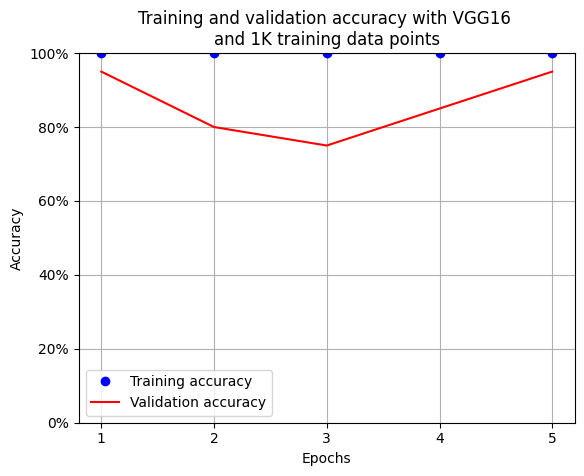

In [33]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.0,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

## Facial Key point Detection

In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
root_dir = 'data/P1_Facial_Keypoints-master/data/'
all_img_path = glob.glob(os.path.join(root_dir,'training/*.jpg'))
data = pd.read_csv(root_dir+'training_frames_keypoints.csv')

In [4]:
data.iloc[0:1]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0


In [5]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [43]:
class FacesData(Dataset):
    def __init__(self,df):
        super().__init__()
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = 'data/P1_Facial_Keypoints-master/data/training/'+self.df.iloc[index,0]  #integer location
        img = cv2.imread(img_path)/255
        kp = deepcopy(self.df.iloc[index,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return kp2,img
    
    def preprocess_input(self,img):
        img = cv2.resize(img,(224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    
    def load_image(self,idx):
        img_path = 'data/P1_Facial_Keypoints-master/data/training/'+self.df.iloc[idx,0]  #integer location
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img,(224,224))
        return img

In [44]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size=0.2,random_state=101)

train_ds = FacesData(train.head(20).reset_index(drop = True))
test_ds = FacesData(test.head(20).reset_index(drop = True))

train_dl = DataLoader(train_ds , batch_size=32,shuffle=True)
test_dl = DataLoader(test_ds , batch_size=32,shuffle=True)

In [33]:
def get_model():
    model = models.vgg16(weights=True)
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.Sequential(nn.Conv2d(512,512,3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )


    model.classifier = nn.Sequential(
        nn.Linear(2048,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,136),
        nn.Sigmoid()
    )
    criterion = nn.L1Loss() #IMPORTANT
    optimizer = torch.optim.Adam(model.parameters(),.002)
    return model,criterion,optimizer

In [34]:
model, criterion, optimizer = get_model()

c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

In [19]:
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [20]:
train_loss, test_loss = [], []
n_epochs = 5
for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 5")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (kps,img) in enumerate(train_dl):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)
    for ix,(kps,img) in enumerate(test_dl):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1 : 5
 epoch 2 : 5
 epoch 3 : 5
 epoch 4 : 5
 epoch 5 : 5


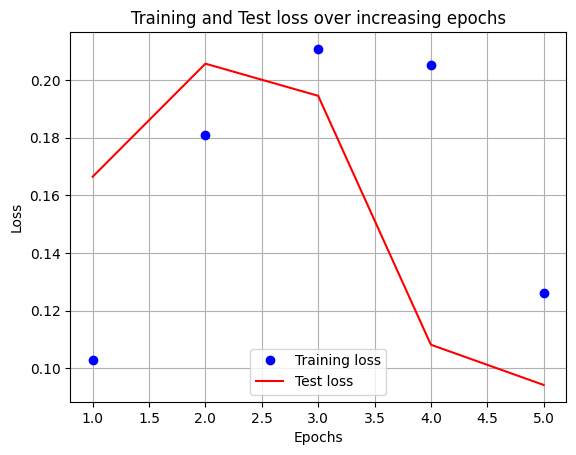

In [21]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
(136,)


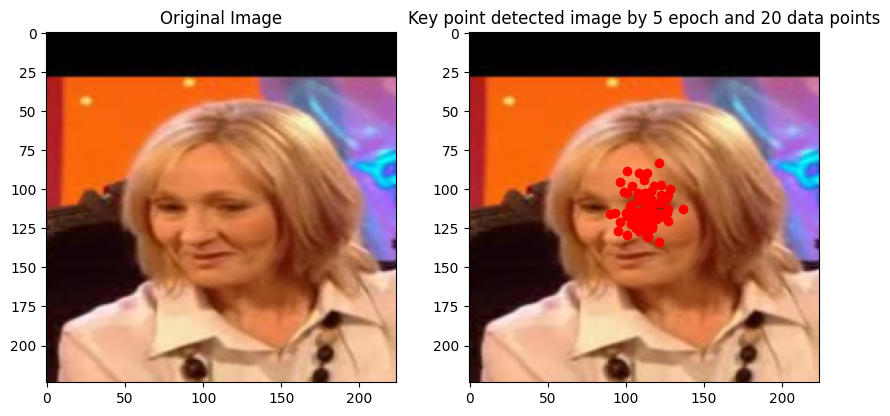

In [61]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Original Image')
img0 = test_ds.load_image(ix)
print (type(img0))
plt.imshow(img0)


#result = model(img0[None]) wont work since input is not of type numpy array
kps , imgTensor = test_ds[ix]
print (type(imgTensor)) 
print (imgTensor.shape)
print (imgTensor[None].shape)
#model(imgTensor) WON'T WORK SINCE NUMBER OF CHANNELS HAS NOT BEEN PASSED TO CNN MODEL
evaluated_kps = model(imgTensor[None]).detach().numpy()[0] #SHOULD BE TRANSFORMED TO NUMPY ARRAY
print(evaluated_kps.shape)
plt.subplot(222)
plt.title("Key point detected image by 5 epoch and 20 data points")
plt.imshow(img0)
plt.scatter(evaluated_kps[:68]*224,evaluated_kps[68:]*224,c='r')

 epoch 1 : 10
 epoch 2 : 10
 epoch 3 : 10
 epoch 4 : 10
 epoch 5 : 10
 epoch 6 : 10
 epoch 7 : 10
 epoch 8 : 10
 epoch 9 : 10
 epoch 10 : 10


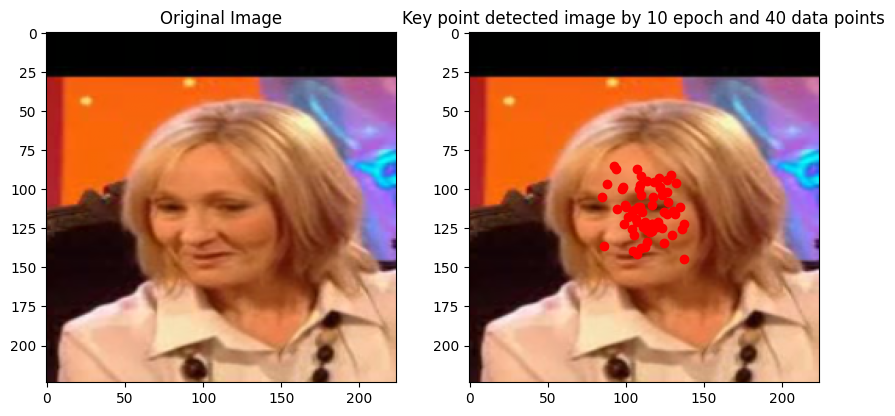

In [62]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size=0.2,random_state=101)

train_ds = FacesData(train.head(40).reset_index(drop = True))
test_ds = FacesData(test.head(40).reset_index(drop = True))

train_dl = DataLoader(train_ds , batch_size=32,shuffle=True)
test_dl = DataLoader(test_ds , batch_size=32,shuffle=True)
train_loss, test_loss = [], []
n_epochs = 10
for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 10")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (kps,img) in enumerate(train_dl):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)
    for ix,(kps,img) in enumerate(test_dl):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)



ix = 0
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Original Image')
img0 = test_ds.load_image(ix)
plt.imshow(img0)


kps , imgTensor = test_ds[ix]
evaluated_kps = model(imgTensor[None]).detach().numpy()[0] #SHOULD BE TRANSFORMED TO NUMPY ARRAY
plt.subplot(222)
plt.title("Key point detected image by 10 epoch and 40 data points")
plt.imshow(img0)
plt.scatter(evaluated_kps[:68]*224,evaluated_kps[68:]*224,c='r')

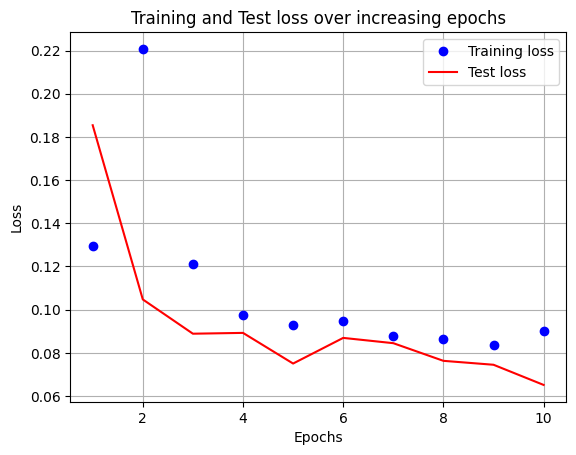

In [63]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

 epoch 1 : 20
 epoch 2 : 20
 epoch 3 : 20
 epoch 4 : 20
 epoch 5 : 20
 epoch 6 : 20
 epoch 7 : 20
 epoch 8 : 20
 epoch 9 : 20
 epoch 10 : 20
 epoch 11 : 20
 epoch 12 : 20
 epoch 13 : 20
 epoch 14 : 20
 epoch 15 : 20
 epoch 16 : 20
 epoch 17 : 20
 epoch 18 : 20
 epoch 19 : 20
 epoch 20 : 20


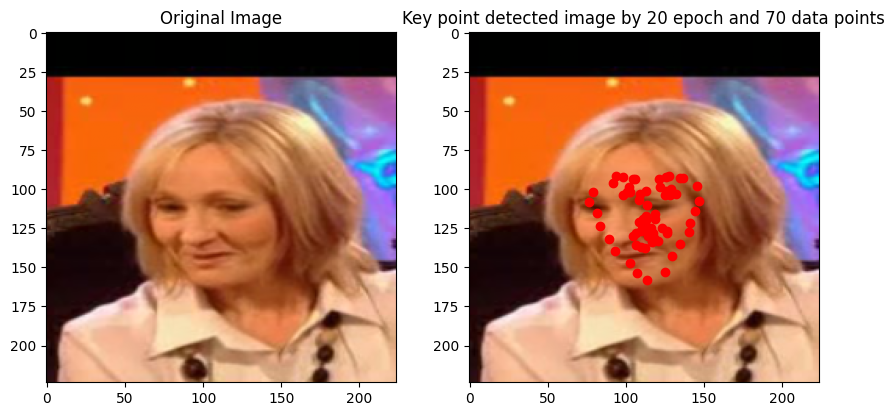

In [64]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size=0.2,random_state=101)

train_ds = FacesData(train.head(70).reset_index(drop = True))
test_ds = FacesData(test.head(70).reset_index(drop = True))

train_dl = DataLoader(train_ds , batch_size=32,shuffle=True)
test_dl = DataLoader(test_ds , batch_size=32,shuffle=True)
train_loss, test_loss = [], []
n_epochs = 20
for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 20")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (kps,img) in enumerate(train_dl):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)
    for ix,(kps,img) in enumerate(test_dl):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)



ix = 0
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Original Image')
img0 = test_ds.load_image(ix)
plt.imshow(img0)


kps , imgTensor = test_ds[ix]
evaluated_kps = model(imgTensor[None]).detach().numpy()[0] #SHOULD BE TRANSFORMED TO NUMPY ARRAY
plt.subplot(222)
plt.title("Key point detected image by 20 epoch and 70 data points")
plt.imshow(img0)
plt.scatter(evaluated_kps[:68]*224,evaluated_kps[68:]*224,c='r')

In [65]:
import face_alignment
fa = face_alignment.FaceAlignment(landmarks_type=face_alignment.LandmarksType.TWO_D,flip_input=False,device='cpu')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to C:\Users\MASOUD/.cache\torch\hub\checkpoints\s3fd-619a316812.pth
100.0%
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to C:\Users\MASOUD/.cache\torch\hub\checkpoints\2DFAN4-cd938726ad.zip
100.0%


In [68]:
img0.shape

(224, 224, 3)

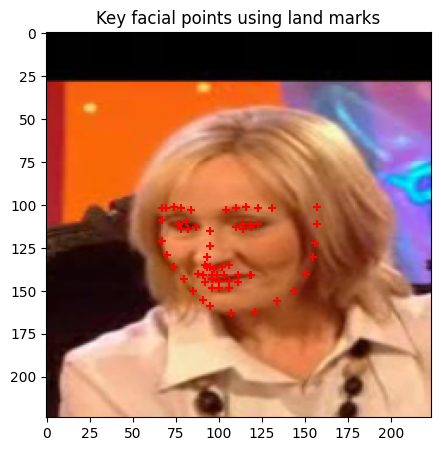

In [77]:
preds = fa.get_landmarks(img0*255)[0]
fig,ax = plt.subplots(figsize=(5,5))
plt.title("Key facial points using land marks")
plt.imshow(img0)
ax.scatter(preds[:,0], preds[:,1], marker='+', c='r')
plt.show()

In [79]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.THREE_D,flip_input=False, device='cpu')
preds = fa.get_landmarks(img0*255)[0]
import pandas as pd
df = pd.DataFrame(preds)
df.columns = ['x','y','z']
import plotly.express as px
fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z')
fig.show()